<a href="https://colab.research.google.com/github/rimeh00/gomycode/blob/main/classification_evnt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

In [67]:
from google.colab import files

In [68]:
files.upload()
df=pd.read_csv('waitlist_kidney_brazil.csv', encoding='latin-1')

Saving waitlist_kidney_brazil.csv to waitlist_kidney_brazil (1).csv


In [69]:
df.head()

,Id,date,age_at_list_registration,age_cat,time_on_Dialysis,race,sex,underline_disease,diabetes,Blood_type,number_transfusion,gestation,number_gestation,prior_transplant,number_prior_transplant,subregion,cPRA,cPRA_cat,HLA_A1,HLA_A2,HLA_B1,HLA_B2,HLA_DR1,HLA_DR2,DR_00,B_00,A_00,calculated_frequency_DR.f1,calculated_frequency_DR.f2,calculated_frequency_DR.f,calculated_frequency_B.f1,calculated_frequency_B.f2,calculated_frequency_B.f,calculated_frequency_A.f1,calculated_frequency_A.f2,calculated_frequency_A.f,chagas,anti.HBc,anti.HCV,agHBs,patient_still_on_list,date_acutal,death,Time_death,Transplant,Transplant_Y_N,X36MthsTx,Time_Tx,priorization,removed_list,razon_removed,time,event
0,4,2017-06-29,67,Maior.60,1.0,Branca,M,Outras,1,A,0,Não,NaN,Não,0,UNIFESP,0,Zero,1,26,44,51,3,7,heterozigoto,heterozigoto,heterozigoto,0.18,0.22,3.96,0.20,0.14,2.80,0.17,0.06,1.02,Não,Não,Não,Não,Sim,43307,Não,13,Não,Não,0,13.07,Não,Não,NaN,392,0
1,5,2008-11-03,58,18.a.60,4.0,Branca,M,Diabetes,0,A,0,Não,NaN,Não,0,UNICAMP,0,Zero,1,24,18,35,11,0,homozigoto,heterozigoto,heterozigoto,0.23,0.00,0.00,0.09,0.21,1.89,0.17,0.16,2.72,Não,Não,Não,Não,Não,43307,Sim,69,Óbito Lista,Não,0,68.87,Não,Não,NaN,2066,2
2,6,2010-07-13,51,18.a.60,2.0,Branca,M,HAS,1,O,0,Não,NaN,Não,0,UNIFESP,64,Entre_50_80,24,25,14,18,1,15,heterozigoto,heterozigoto,heterozigoto,0.19,0.21,3.99,0.10,0.09,0.90,0.16,0.02,0.32,Não,Não,Não,Não,Não,43307,Não,98,Não,Não,0,12.17,Não,Sim,Removido (suspenso > 365 dias),365,3
3,7,2011-10-03,52,18.a.60,17.0,Branca,M,Diabetes,0,O,0,Não,NaN,Sim,1,UNIFESP,2,Entre_0_50,24,25,14,18,1,15,heterozigoto,heterozigoto,heterozigoto,0.19,0.21,3.99,0.10,0.09,0.90,0.16,0.02,0.32,Não,Não,Não,Não,Não,43307,Não,83,Não,Não,0,12.17,Não,Sim,Removido (suspenso > 365 dias),365,3
4,8,2006-07-05,67,Maior.60,68.0,Parda,M,HAS,1,A,0,Não,NaN,Não,0,UNIFESP,0,Zero,24,68,14,27,13,15,heterozigoto,heterozigoto,heterozigoto,0.25,0.21,5.25,0.10,0.04,0.40,0.16,0.13,2.08,Não,Não,Não,Não,Não,43307,Sim,6,Óbito Lista,Não,0,6.47,Não,Não,NaN,194,2


la base de données renferme plusieurs informations selon le devenir de chaque malade inscrit sur la liste d'attente, 0- patient encore inscris 1- si il a eu une transplantation, et le temps de l'evenement, 2- deces 3- annulation de l'inscription résumés dans la colonne: 'event'
ce qu'on pourrait faire: un model de classification pour prédire l'evenement le plus probable, et des modèles secondaires de classification pour déterminer chaque évenement à part
la deuxième chose, c'est d'essayer de faire un model basée sur time-to-event prediction en associant la cox-regression et le gradient boost 

In [70]:
# cleaning data function
def cleaning_data(data, column, function, condition=None, replacement=None, second= None):
  if function== 'drop':
    data= data.drop([column], axis=1, inplace= True)
  elif function== 'fillna':
    if second== 'mean':
      data[column].fillna(data[column].mean()[0], inplace=True)
    elif second== 'mode':
      data[column].fillna(data[column].mode()[0], inplace= True)
    elif second == 'median':
      data[column].fillna(data[column].median()[0], inplace= True)
    else:
      data[column].fillna(int(second), inplace=True)
  elif function== 'one hot':
    one_hot= pd.get_dummies(data[column])
    data=data.join(one_hot)
  elif function== 'label encoder':
    from sklearn.preprocessing import LabelEncoder
    encoder=LabelEncoder()
    new= column+ '_encoded'
    data[new]=encoder.fit_transform(data[column])
  elif function== 'where':
    data[column].where(condition, replacement, inplace=True)

In [71]:
#these variables won't be of necessary use during all the work, we'll get rid of them 
df.drop(['Id','race','chagas','anti.HCV','gestation','prior_transplant','date'],axis=1, inplace=True)

In [72]:
df.drop(['agHBs','razon_removed'], axis=1, inplace=True)

In [73]:
df.drop(['priorization'], axis=1, inplace=True)

In [74]:
# appliable data preprocessing function to all alternatives classifications
def data_preprocessing (data):
  cleaning_data(data, 'time_on_Dialysis', 'fillna',second='mode')
  cleaning_data(data, 'age_cat', 'label encoder')
  cleaning_data(data,'age_cat','drop')
  cleaning_data(data, 'number_gestation', 'fillna',second='0')
  data['number_gestation'] = data['number_gestation'].astype(int)
  data['number_gestation'].where(data['number_gestation']<20, 20, inplace=True)
  cleaning_data(data,'sex','label encoder')
  cleaning_data(data,'sex','drop')
  cleaning_data(data,'DR_00','label encoder')
  cleaning_data(data,'A_00','label encoder')
  cleaning_data(data,'B_00','label encoder')
  cleaning_data(data,'anti.HBc','label encoder')
  data.drop(['A_00','B_00','DR_00','anti.HBc'], axis=1, inplace= True)



Trial 1: classifing the patients according to the event

In [75]:
x_event= df.drop(['event'], axis=1)
y_event=df['event']

In [76]:
# splitting the data before any data preprocessing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_event, y_event, test_size = 0.2, random_state=0)

In [77]:
# x_train preprocessing
data_preprocessing(X_train)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib

In [78]:
X_train

,age_at_list_registration,time_on_Dialysis,underline_disease,diabetes,Blood_type,number_transfusion,number_gestation,number_prior_transplant,subregion,cPRA,cPRA_cat,HLA_A1,HLA_A2,HLA_B1,HLA_B2,HLA_DR1,HLA_DR2,calculated_frequency_DR.f1,calculated_frequency_DR.f2,calculated_frequency_DR.f,calculated_frequency_B.f1,calculated_frequency_B.f2,calculated_frequency_B.f,calculated_frequency_A.f1,calculated_frequency_A.f2,calculated_frequency_A.f,patient_still_on_list,date_acutal,death,Time_death,Transplant,Transplant_Y_N,X36MthsTx,Time_Tx,removed_list,time,age_cat_encoded,sex_encoded,DR_00_encoded,A_00_encoded,B_00_encoded,anti.HBc_encoded
43823,48,17.0,Outras,1,A,0,0,0,HCFMUSP,0,Zero,11,30,0,14,11,15,0.23,0.21,4.83,0.00,0.10,0.00,0.10,0.13,1.30,Não,43307,Sim,51,Óbito Lista,Não,0,51.13,Não,1534,0,1,0,0,1,0
16810,50,8.0,HAS,1,O,1,0,0,UNIFESP,0,Zero,2,0,44,58,7,11,0.22,0.23,5.06,0.20,0.07,1.40,0.42,0.00,0.00,Sim,43307,Não,18,Não,Não,0,17.80,Não,534,0,1,0,1,0,0
11468,58,16.0,GNC,1,O,1,3,0,HCFMUSP,35,Entre_0_50,2,68,44,45,3,15,0.18,0.21,3.78,0.20,0.05,1.00,0.42,0.13,5.46,Sim,43307,Não,45,Não,Não,0,45.23,Não,1357,0,0,0,0,0,0
32941,42,6.0,Outras,1,O,0,3,0,UNIFESP,0,Zero,3,74,14,81,7,12,0.22,0.04,0.88,0.10,0.02,0.20,0.18,0.04,0.72,Não,43307,Sim,15,Óbito Lista,Não,0,15.47,Não,464,0,0,0,0,0,0
32499,66,22.0,GNC,1,B,2,2,2,HCFMUSP,0,Zero,2,74,42,58,8,13,0.12,0.25,3.00,0.04,0.07,0.28,0.42,0.04,1.68,Não,43307,Sim,4,Sim,Sim,1,3.80,Não,114,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21243,49,12.0,Diabetes,0,B,1,0,0,UNIFESP,0,Zero,3,74,14,35,11,15,0.23,0.21,4.83,0.10,0.21,2.10,0.18,0.04,0.72,Sim,43307,Não,25,Não,Não,0,24.50,Não,735,0,1,0,0,0,0
45891,62,36.0,Outras,1,A,0,0,1,HCFMUSP,0,Zero,11,23,44,55,7,14,0.22,0.07,1.54,0.20,0.03,0.60,0.10,0.11,1.10,Não,43307,Sim,5,Óbito Lista,Não,0,5.37,Não,161,1,1,0,0,0,0
42613,6,24.0,Outras,1,B,1,0,0,HCFMUSP,0,Zero,2,0,51,58,11,13,0.23,0.25,5.75,0.14,0.07,0.98,0.42,0.00,0.00,Não,43307,Não,36,Sim,Sim,1,2.93,Não,88,2,1,0,1,0,0
43567,55,11.0,Outras,1,A,0,2,0,UNIFESP,0,Zero,2,0,49,50,4,7,0.23,0.22,5.06,0.05,0.04,0.20,0.42,0.00,0.00,Não,43307,Não,39,Não,Não,0,14.00,Sim,420,0,0,0,1,0,0


In [79]:
# for this classification, we won,t use a time variable, therefore we will delete them, and label encode the remainig events and see if ther is any correlations
def event_processing(data):
  data.drop(['date_acutal','Time_death','Transplant','X36MthsTx','Time_Tx','time'], axis=1, inplace=True)
  cleaning_data(data, 'patient_still_on_list','label encoder')
  cleaning_data(data, 'death','label encoder')
  cleaning_data(data, 'Transplant_Y_N','label encoder')
  cleaning_data(data, 'removed_list','label encoder')
  data.drop(['death','removed_list','Transplant_Y_N','patient_still_on_list'],axis=1, inplace=True)


In [80]:
# one hot encoding the categorical data 
def one_hotting(data):
  one_hot1= pd.get_dummies(data['Blood_type'])
  data=data.join(one_hot1)
  one_hot2= pd.get_dummies(data['cPRA_cat'])
  data=data.join(one_hot2)
  one_hot3= pd.get_dummies(data['subregion'])
  data=data.join(one_hot3)
  one_hot4= pd.get_dummies(data['underline_disease'])
  data=data.join(one_hot4)
  data.drop(['underline_disease','cPRA_cat','Blood_type','subregion'], axis=1, inplace=True)

  

  


In [81]:
event_processing(X_train)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [82]:
one_hot1= pd.get_dummies(X_train['Blood_type'])
X_train=X_train.join(one_hot1)

In [83]:
one_hot2= pd.get_dummies(X_train['cPRA_cat'])
X_train=X_train.join(one_hot2)

In [84]:
one_hot3= pd.get_dummies(X_train['subregion'])
X_train=X_train.join(one_hot3)

In [85]:
one_hot4= pd.get_dummies(X_train['underline_disease'])
X_train=X_train.join(one_hot4)

In [86]:
X_train.drop(['underline_disease','cPRA_cat','subregion','Blood_type'], axis=1, inplace=True)

In [87]:
X_train.dtypes

age_at_list_registration           int64
time_on_Dialysis                 float64
diabetes                           int64
number_transfusion                 int64
number_gestation                   int64
number_prior_transplant            int64
cPRA                               int64
HLA_A1                             int64
HLA_A2                             int64
HLA_B1                             int64
HLA_B2                             int64
HLA_DR1                            int64
HLA_DR2                            int64
calculated_frequency_DR.f1       float64
calculated_frequency_DR.f2       float64
calculated_frequency_DR.f        float64
calculated_frequency_B.f1        float64
calculated_frequency_B.f2        float64
calculated_frequency_B.f         float64
calculated_frequency_A.f1        float64
calculated_frequency_A.f2        float64
calculated_frequency_A.f         float64
age_cat_encoded                    int64
sex_encoded                        int64
DR_00_encoded   

In [88]:
X_train

,age_at_list_registration,time_on_Dialysis,diabetes,number_transfusion,number_gestation,number_prior_transplant,cPRA,HLA_A1,HLA_A2,HLA_B1,HLA_B2,HLA_DR1,HLA_DR2,calculated_frequency_DR.f1,calculated_frequency_DR.f2,calculated_frequency_DR.f,calculated_frequency_B.f1,calculated_frequency_B.f2,calculated_frequency_B.f,calculated_frequency_A.f1,calculated_frequency_A.f2,calculated_frequency_A.f,age_cat_encoded,sex_encoded,DR_00_encoded,A_00_encoded,B_00_encoded,anti.HBc_encoded,patient_still_on_list_encoded,death_encoded,Transplant_Y_N_encoded,removed_list_encoded,A,AB,B,O,Entre_0_50,Entre_50_80,Maior_80,Zero,FUNDERP,HCFMUSP,UNICAMP,UNIFESP,Diabetes,GNC,HAS,Outras,Pielonefrite
43823,48,17.0,1,0,0,0,0,11,30,0,14,11,15,0.23,0.21,4.83,0.00,0.10,0.00,0.10,0.13,1.30,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
16810,50,8.0,1,1,0,0,0,2,0,44,58,7,11,0.22,0.23,5.06,0.20,0.07,1.40,0.42,0.00,0.00,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0
11468,58,16.0,1,1,3,0,35,2,68,44,45,3,15,0.18,0.21,3.78,0.20,0.05,1.00,0.42,0.13,5.46,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0
32941,42,6.0,1,0,3,0,0,3,74,14,81,7,12,0.22,0.04,0.88,0.10,0.02,0.20,0.18,0.04,0.72,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0
32499,66,22.0,1,2,2,2,0,2,74,42,58,8,13,0.12,0.25,3.00,0.04,0.07,0.28,0.42,0.04,1.68,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21243,49,12.0,0,1,0,0,0,3,74,14,35,11,15,0.23,0.21,4.83,0.10,0.21,2.10,0.18,0.04,0.72,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0
45891,62,36.0,1,0,0,1,0,11,23,44,55,7,14,0.22,0.07,1.54,0.20,0.03,0.60,0.10,0.11,1.10,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
42613,6,24.0,1,1,0,0,0,2,0,51,58,11,13,0.23,0.25,5.75,0.14,0.07,0.98,0.42,0.00,0.00,2,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
43567,55,11.0,1,0,2,0,0,2,0,49,50,4,7,0.23,0.22,5.06,0.05,0.04,0.20,0.42,0.00,0.00,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0


In [89]:
# scaling the data
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_train['age_at_list_registration']= scaler.fit_transform(X_train[['age_at_list_registration']])

In [90]:
X_train['time_on_Dialysis']= scaler.fit_transform(X_train[['time_on_Dialysis']])

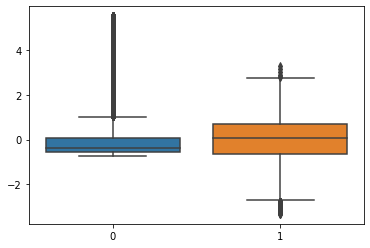

In [91]:
sns.boxplot(data=[X_train['time_on_Dialysis'], X_train['age_at_list_registration']])

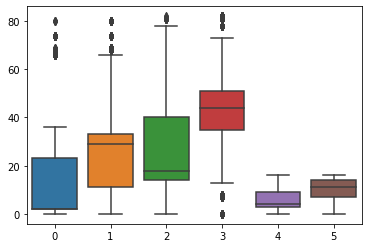

In [92]:
sns.boxplot(data=[X_train['HLA_A1'], X_train['HLA_A2'], X_train['HLA_B1'],X_train['HLA_B2'], X_train['HLA_DR1'], X_train['HLA_DR2']])

In [93]:
# x_test preprocessing
data_preprocessing(X_test)
event_processing(X_test)



/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib

In [94]:
one_hot1= pd.get_dummies(X_test['Blood_type'])
X_test=X_test.join(one_hot1)

In [95]:
one_hot2= pd.get_dummies(X_test['cPRA_cat'])
X_test=X_test.join(one_hot2)

In [96]:
one_hot3= pd.get_dummies(X_test['subregion'])
X_test=X_test.join(one_hot3)

In [97]:
one_hot4= pd.get_dummies(X_test['underline_disease'])
X_test=X_test.join(one_hot4)

In [98]:
X_test.drop(['underline_disease','cPRA_cat','subregion','Blood_type'], axis=1, inplace=True)

In [99]:
X_test

,age_at_list_registration,time_on_Dialysis,diabetes,number_transfusion,number_gestation,number_prior_transplant,cPRA,HLA_A1,HLA_A2,HLA_B1,HLA_B2,HLA_DR1,HLA_DR2,calculated_frequency_DR.f1,calculated_frequency_DR.f2,calculated_frequency_DR.f,calculated_frequency_B.f1,calculated_frequency_B.f2,calculated_frequency_B.f,calculated_frequency_A.f1,calculated_frequency_A.f2,calculated_frequency_A.f,age_cat_encoded,sex_encoded,DR_00_encoded,A_00_encoded,B_00_encoded,anti.HBc_encoded,patient_still_on_list_encoded,death_encoded,Transplant_Y_N_encoded,removed_list_encoded,A,AB,B,O,Entre_0_50,Entre_50_80,Maior_80,Zero,FUNDERP,HCFMUSP,UNICAMP,UNIFESP,Diabetes,GNC,HAS,Outras,Pielonefrite
39727,52,11.0,1,0,0,0,31,2,33,14,39,1,4,0.19,0.23,4.37,0.10,0.06,0.60,0.42,0.07,2.94,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0
19877,45,11.0,1,0,0,0,0,26,30,38,56,3,13,0.18,0.25,4.50,0.03,0.01,0.03,0.06,0.13,0.78,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0
46061,63,72.0,1,0,0,1,0,0,3,15,81,11,15,0.23,0.21,4.83,0.19,0.02,0.38,0.00,0.18,0.00,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0
44815,70,35.0,1,3,7,0,0,0,2,7,44,11,15,0.23,0.21,4.83,0.14,0.20,2.80,0.00,0.42,0.00,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
7570,64,56.0,0,0,2,0,0,24,0,8,40,3,16,0.18,0.07,1.26,0.08,0.09,0.72,0.16,0.00,0.00,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,52,9.0,0,0,0,0,0,11,29,44,0,4,7,0.23,0.22,5.06,0.20,0.00,0.00,0.10,0.08,0.80,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0
10604,46,10.0,0,1,0,0,0,3,32,14,38,7,13,0.22,0.25,5.50,0.10,0.03,0.30,0.18,0.06,1.08,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0
44361,48,65.0,0,0,5,1,99,1,30,8,57,3,0,0.18,0.00,0.00,0.08,0.06,0.48,0.17,0.13,2.21,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0
24547,78,18.0,1,0,0,0,0,3,68,7,40,4,15,0.23,0.21,4.83,0.14,0.09,1.26,0.18,0.13,2.34,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0


In [100]:

X_test['age_at_list_registration']= scaler.fit_transform(X_test[['age_at_list_registration']])

In [101]:

X_test['time_on_Dialysis']= scaler.fit_transform(X_test[['time_on_Dialysis']])

In [102]:
# getting our classification modell

In [103]:
!pip install xgboost

In [104]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [105]:
def model_performance (x, y, y_pred):
  accuracy=print('score:{}'.format(accuracy_score(y, y_pred)))
  classy = print(classification_report(y,y_pred))
  confusion_matrix = pd.crosstab(y, y_pred, rownames=['Actual'], colnames=['Predicted'])
  viz= sns.heatmap(confusion_matrix, annot=True)
  return accuracy, classy, viz

In [106]:
#using random forrest model
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=10) 
clf.fit(X_train, y_train)  
y_predd=clf.predict(X_test)

In [107]:
from sklearn.metrics import classification_report

score:0.9998961686221576
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2135
           1       1.00      1.00      1.00      2789
           2       1.00      1.00      1.00      1827
           3       1.00      1.00      1.00      2880

    accuracy                           1.00      9631
   macro avg       1.00      1.00      1.00      9631
weighted avg       1.00      1.00      1.00      9631



(None, None, <matplotlib.axes._subplots.AxesSubplot at 0x7fe9d01039d0>)

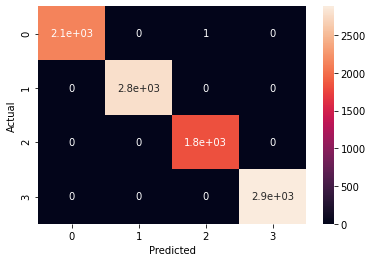

In [108]:
model_performance(X_test, y_test, y_predd)

In [109]:
from xgboost import XGBClassifier

In [110]:
model =XGBClassifier(n_estimators=4 ,objective='multi:softmax', num_class=4,       
                         seed=123)

In [111]:
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [112]:
# let's check the model efficiency
accuracy = float((np.sum(preds==y_test))/y_test.shape[0])

print("accuracy: %f" % (accuracy))

accuracy: 1.000000
